# Flow(홍수정님)

![image](drawio.jpg)

## Import


In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

import urllib.request

nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Step 1. 데이터 수집하기

## Data Load

- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 
- 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요

In [5]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('data/news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [7]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 2.1) text 중복 제거

In [8]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# text 중복제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.2) 결측치 제거

In [10]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.3) 텍스트 정규화와 불용어 제거

- ex) 
    - it'll -> it will
    - mustn't -> must not

In [1]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NameError: name 'stopwords' is not defined

In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
data['text'] = data['text'].apply(lambda x : preprocess_sentence(x))

In [16]:
data['headlines'] = data['headlines'].apply(lambda x : preprocess_sentence(x,False))

## 2.4) '텍스트 정규화와 불용어 제거' 후 결측치 제거

In [17]:
# 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## (추가) '전처리 된' 데이터 저장 및 불러오기

### 전처리 끝난 데이터 '저장'

In [21]:
# 전처리 끝난 데이터 저장
#data.to_csv('data/preprocessed_data.csv')

### 전치리 끝난 데이터 '불러옥이'

In [2]:
# 전처리 끝난 데이터 불러오기
data = pd.read_csv(os.path.join('data', 'preprocessed_data.csv'))
data.head()

,Unnamed: 0,headlines,text
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


## 2.5) 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


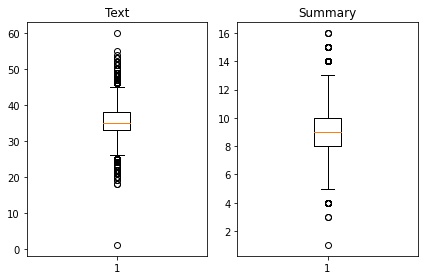

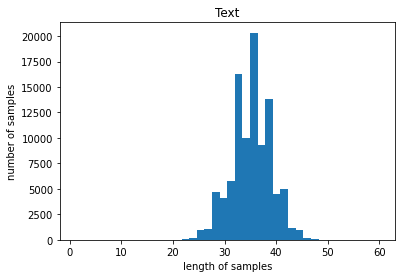

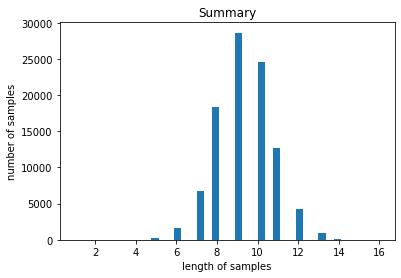

In [3]:
# 샘플의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [4]:
# 길이 지정
text_max_len = 50
summary_max_len = 14

In [5]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list)*100)))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.98576657177715
전체 샘플 중 길이가 14 이하인 샘플의 비율: 99.97763318422123


## 2.6) 샘플 최대 길이 넘는 행 제거

In [6]:
# 샘플 길이 안넘는 애들만 살리기
# 샘플 길이를 넘으면 사용안함
# text_max_len = 50
# summary_max_len = 14
def check_length(row):
    text_len = len(row['text'].split())
    summary_len = len(row['headlines'].split())
    return text_len <= text_max_len and summary_len <= summary_max_len

# apply 함수와 lambda 식을 사용하여 조건에 맞는 샘플만 남기기
data = data[data.apply(lambda row: check_length(row), axis=1)]

# 결과 출력
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98324


## 2.7) (디코더) 시작, 종료 토큰 추가

In [7]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,Unnamed: 0,headlines,text,decoder_input,decoder_target
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


## 2.8) train/test 나누기

In [8]:
# train/test 나누기 1
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [9]:
# train/test 나누기 2
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[27556 60157 36866 ... 45666 85492 91303]


In [10]:
# train/test 나누기 3
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [11]:
# 8 : 2
n_of_val = int(len(encoder_input)*0.2)

In [12]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


## 2.9) 제거됨

## 2.10) 'text' 빈도수 적은 희귀 단어 제거

In [14]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69612
등장 빈도가 6번 이하인 희귀 단어의 수: 47446
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22166
단어 집합에서 희귀 단어의 비율: 68.15778888697352
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4928455491285093


In [15]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [16]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 745, 12, 27, 1460, 1017, 85, 27, 19, 1017, 103, 7, 359, 51, 2202, 245, 59, 19, 143, 74, 516, 1506, 93, 216, 31, 19, 143, 374, 2, 7786, 2148, 6, 1268, 93, 359, 663], [38, 56, 168, 182, 386, 1423, 360, 291, 184, 230, 12, 344, 57, 660, 94, 1423, 459, 291, 184, 105, 29, 787, 1925, 5375, 7, 2275, 184, 489], [1476, 35, 2130, 2149, 7557, 1794, 44, 18, 6191, 1195, 70, 79, 42, 1868, 1881, 1618, 2977, 68, 374, 42, 7557, 2759, 436, 474, 649, 253, 1106, 409, 194, 1415, 2977, 5376, 48, 1]]


## 2.11) 'headlines' 빈도수 적은 희귀 단어 제거

In [17]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30140
등장 빈도가 5번 이하인 희귀 단어의 수: 19712
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10428
단어 집합에서 희귀 단어의 비율: 65.4014598540146
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.644402513237967


In [18]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9, 183, 55, 1267, 1722, 4, 1209], [1, 32, 760, 975, 422, 6, 1859, 5, 312, 243], [1, 834, 72, 51, 6, 570, 144], [1, 263, 3, 736, 67, 43, 4, 368], [1, 620, 568, 1747, 1860, 1492, 292, 183]]
target
decoder  [[9, 183, 55, 1267, 1722, 4, 1209, 2], [32, 760, 975, 422, 6, 1859, 5, 312, 243, 2], [834, 72, 51, 6, 570, 144, 2], [263, 3, 736, 67, 43, 4, 368, 2], [620, 568, 1747, 1860, 1492, 292, 183, 2]]


## 2.12) 비어있는 text & headline 삭제

In [19]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 15
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78645
훈련 레이블의 개수 : 78645
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


## 2.13) 패딩 

In [20]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## 3.1) encoder

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs3, state_h3, state_c3= encoder_lstm3(encoder_output2)


encoder_outputs = encoder_outputs3
state_h = state_h3
state_c = state_c3

## 3.2) decoder

In [22]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## 3.3) 출력층

In [23]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3.4) 어텐션

In [24]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3.5) 모델 학습

- EarlyStopping 적용

In [25]:
model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy'
)
es = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    verbose=1
)
history = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train, 
    validation_data=(
        [encoder_input_test, 
         decoder_input_test
        ], 
    decoder_target_test), 
    batch_size=256, 
    callbacks=[es], 
    epochs=20
)

Epoch 1/20
308/308 [==============================] - 150s 460ms/step - loss: 3.3555 - val_loss: 3.0975
Epoch 2/20
308/308 [==============================] - 143s 463ms/step - loss: 2.9523 - val_loss: 2.8154
Epoch 3/20
308/308 [==============================] - 143s 465ms/step - loss: 2.6997 - val_loss: 2.6296
Epoch 4/20
308/308 [==============================] - 140s 454ms/step - loss: 2.5422 - val_loss: 2.5095
Epoch 5/20
308/308 [==============================] - 139s 452ms/step - loss: 2.4233 - val_loss: 2.4292
Epoch 6/20
308/308 [==============================] - 142s 461ms/step - loss: 2.3264 - val_loss: 2.3496
Epoch 7/20
308/308 [==============================] - 138s 449ms/step - loss: 2.2463 - val_loss: 2.2940
Epoch 8/20
308/308 [==============================] - 144s 468ms/step - loss: 2.1769 - val_loss: 2.2440
Epoch 9/20
308/308 [==============================] - 138s 448ms/step - loss: 2.1156 - val_loss: 2.2110
Epoch 10/20
308/308 [==============================] - 138s 447m

In [27]:
# 모델 저장
#model.save('trained_model.h5')

## 3.6) 결과 그래프

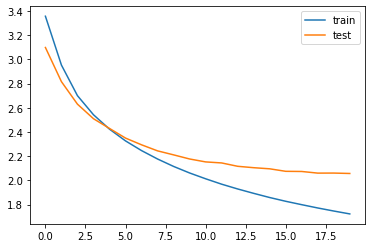

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

## 4.1) 인퍼런스(추론) 모델 구현하기

In [28]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [29]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [30]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4.2) 모델 테스트하기

In [32]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [33]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bangladesh internet services across country suspended services hours prevent propaganda misleading content spreading internet ahead general elections official said bangladesh regulatory commission earlier blocked website opposition bangladesh nationalist party along news websites 
실제 요약 : services suspended in bangladesh ahead of elections 
예측 요약 :  bangladesh suspends internet amid internet


원문 : delivering union budget speech finance minister arun jaitley thursday said india trillion economy path growth also announced budget focused rural economy health infrastructure also said natural resources allocated transparent manner 
실제 요약 : india is trillion economy on for growth fm 
예측 요약 :  india growth rate to economy economy


원문 : filmmaker said arjun rampal directed actor potential feel actually someone potential need know offer able push added arjun next seen upcoming film daddy directed 
실제 요약 : arjun is an under actor 
예측 요약 :  arjun is the of arjun


원문 : district administrat

- *비교 결과* :
    - 단어는 주로 일치해 보이지만, 순서가 많이 다름
    - 디테일한 부분은 다르지만, 큰 틀은 비슷함
        - 대학 총기 난사 사건의 10대 살인 사건(gun teen kills at college shoots self)
        - 사우디 대사관에서 총격으로 부상을 입은 사람들(killed injured in shooting at saudi embassy)

# Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## 5.1) Summa

- 결론: 대부분의 요약한 결과가 `blank`가 나옴
    - 이유 : Summa에 사용되는 텍스트(원본)의 `길이가 짧아서 추출 요약이 정상적으로 이루어지지 않음`
    - 아래 코드에 있는 `textsummarizer.py`로 대체

In [34]:
import requests
from summa.summarizer import summarize

for i in range(150, 152):
    text = seq2text(encoder_input_test[i])
    print("원문 :", text)
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print('Summa 1 :',summarize(text, ratio=0.005))
    print('Summa 2 :',summarize(text, words=50))
    print("\n")

원문 : cbi said special director rakesh asthana complaint central vigilance commission director alok verma malicious baseless cbi said attempt officers probing role six cases asthana filed complaint alleging cbi chief interfering cases including one rjd chief lalu prasad yadav 
실제 요약 : top officer complaint against director cbi 
Summa 1 : 
Summa 2 : 


원문 : britain european union start brexit negotiations june planned initially negotiations thrown doubt uk prime minister theresa may conservative party lost parliamentary majority snap election last week notably britain member eu years 
실제 요약 : eu to brexit on june 
Summa 1 : 
Summa 2 : 




## 5.2) textsummarizer.py

In [35]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re

def read_article(text):
    sentences =[]
    sentences = sent_tokenize(text)
    for sentence in sentences:
        sentence.replace("[^a-zA-Z0-9]"," ")

    return sentences
    
def sentence_similarity(sent1,sent2,stopwords=None):
    if stopwords is None:
        stopwords = []
    
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    
    for w in sent1:
        if not w in stopwords:
            vector1[all_words.index(w)]+=1
    
    for w in sent2:
        if not w in stopwords:
            vector2[all_words.index(w)]+=1
            
    return 1-cosine_distance(vector1,vector2)

def build_similarity_matrix(sentences,stop_words):
    similarity_matrix = np.zeros((len(sentences),len(sentences)))
    
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1!=idx2:
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2],stop_words)
                
    return similarity_matrix

def generate_summary(text, top_n):
    # 영어 불용어(stop words)를 사용하기 위해 stopwords.words('english')를 호출합니다.
    stop_words = stopwords.words('english')
    summarize_text = []
    
    # 텍스트를 문장 단위로 분리합니다. (read_article 함수 호출)
    sentences = read_article(text)
    
    # 문장 간 유사도 행렬을 생성합니다. (build_similarity_matrix 함수 호출)
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)
    
    # 유사도 그래프를 생성합니다. (넘파이 배열을 이용하여 nx.from_numpy_array 호출)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    
    # 문장별 점수를 계산합니다. (페이지랭크 알고리즘을 사용하여 nx.pagerank 호출)
    scores = nx.pagerank(sentence_similarity_graph)
    
    # 점수에 따라 문장을 정렬합니다.
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    
    # 상위 top_n개의 문장을 선택합니다.
    for i in range(top_n):
        summarize_text.append(ranked_sentences[i][1])
    
    # 선택된 문장들을 하나의 문자열로 결합하여 반환합니다.
    return " ".join(summarize_text), len(sentences)


In [38]:
true = []
pred = []
extract = []

for i in range(0, 10):
    # 원본 text 
    temp_text = seq2text(encoder_input_test[i]) 
    # 실제 headline
    temp_true = seq2summary(decoder_input_test[i])
    true.append(temp_true)
    print(">> 실제 Headline :", temp_true)
    
    # 예측 headline
    temp_pred = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    pred.append(temp_pred)
    print(">> 예측 Headline :", temp_pred)


    temp_ext = generate_summary(temp_text,1)[0]
    extract.append(temp_ext)
    print(">> 추출 요약 :", temp_ext)
    print('=====================================================================')

>> 실제 Headline : amazon founder bezos shares photo with mother 
>> 예측 Headline :  bezos shares old pic of daughter mother
>> 추출 요약 : amazon founder world third richest person jeff bezos took twitter share childhood picture mother following mother day captioned picture lottery mom thanks literally everything mom reacting picture twitter former ceo tweeted hey tie
>> 실제 Headline : china to study human 
>> 예측 Headline :  scientists create of
>> 추출 요약 : chinese scientists five monkeys monkey gene associated human diseases like depression cancer first time multiple made gene monkey research state media reported gene monkey disorder selected donor
>> 실제 Headline : tata says no plans to list land 
>> 예측 Headline :  tata group to buy luxury car reports
>> 추출 요약 : tata motors monday said plans list luxury car brand jaguar land rover reports suggested considering initial public offering unit truth rumours tata spokesperson noted earlier reports stated senior tata officials held preliminary discu

## (추가) 성능평가

- 지표 설명
    - rouge-1 : 예측한 요약문과 실제 요약문 간의 `unigram의 재현율`이다.
    - rouge-2 : 예측한 요약문과 실제 요약문 간의 `bigram 재현율`이다.
    - rouge-l : 가장 긴 공통 시퀀스(LCS)를 기반으로 한다. 두 시퀀스 사이의 LCS란최대 길이를 가지는 공통 하위 시퀀스를 말한다. 따라서 예측 및 실제 요약문에 LCS가 있다는 것은 `예측 요약 문과 실제 요약문이 일치하는 것`이라고 볼수 있다.

In [39]:
!pip install -q rouge

/tmp/ipykernel_2573/1239194333.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[n].set_xticklabels(['recall','recall','precision','f-score','recall','precision','f-score'])


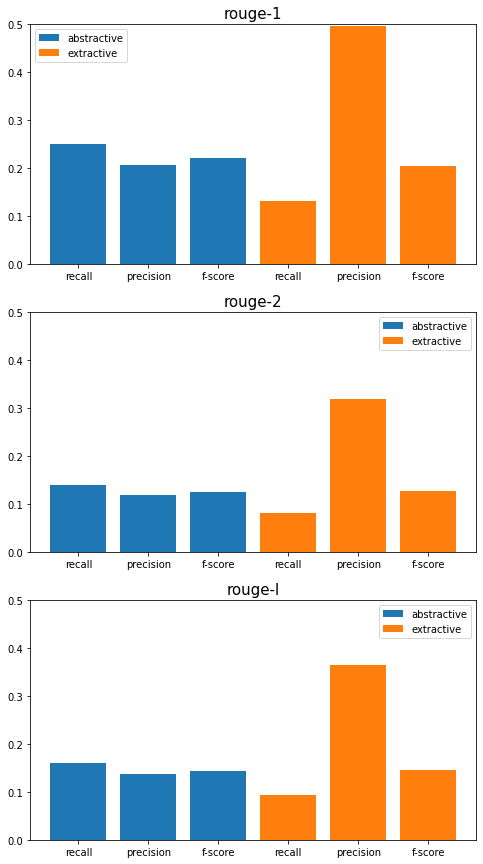

Done


In [40]:
import rouge

pred_score = []
extract_score = []

rscore = rouge.Rouge()

fig, ax = plt.subplots(3,1, figsize = (8, 15))
for n, method in enumerate(['rouge-1','rouge-2','rouge-l']): # 채점 방식 차이 3개
    for i in range(len(true)):
        pred_score.append(rscore.get_scores(true[i], pred[i], avg=True)[method])
        extract_score.append(rscore.get_scores(true[i], extract[i], avg=True)[method])

    pr, er = np.mean([x['r'] for x in pred_score]), np.mean([x['r'] for x in extract_score])
    pp, ep = np.mean([x['p'] for x in pred_score]), np.mean([x['p'] for x in extract_score])
    pf, ef = np.mean([x['f'] for x in pred_score]), np.mean([x['f'] for x in extract_score])

    ax[n].set_title(method, fontsize= 15)

    ax[n].bar([0,1,2], [pr, pp, pf], label = 'abstractive')
    ax[n].bar([3,4,5], [er,ep,ef], label = 'extractive')
    ax[n].set_xticklabels(['recall','recall','precision','f-score','recall','precision','f-score'])
    ax[n].set_ylim([0,0.5])

    ax[n].legend()

plt.show()
print('Done')

- 결과
    - 단어의 일치율(순서 무시)은 추출적 요약이 추상적 요약보다 성능이 우수하다
    
- 원인분석
    1. 추상적 요약에 사용되는 `단어사전`의 한계
        - 해결 방안 : 사전학습된 임베딩 모델(Word2Vec, FastText 등)을 이용하면 성능이 올라가나요?????
    2. 학습에 사용되는 뉴스 원본(text)의 길이가 짧다